In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/datadasprepro

/content/drive/.shortcut-targets-by-id/1IQsmLFvi37-mGbVQl5genAVzEki5rYc4/datadasprepro


In [ ]:
!pwd

/content/drive/.shortcut-targets-by-id/1IQsmLFvi37-mGbVQl5genAVzEki5rYc4/datadasprepro


In [ ]:
!pwd

In [ ]:
!ls /content/drive/MyDrive/datadasprepro

label				 Unet-Mobilenet_v2_mIoU-0.846.pt  Unet-Mobilenet_v2_mIoU-0.876.pt
ori				 Unet-Mobilenet_v2_mIoU-0.856.pt  Unet-Mobilenet_v2_mIoU-0.882.pt
Unet-Mobilenet.pt		 Unet-Mobilenet_v2_mIoU-0.863.pt
Unet-Mobilenet_v2_mIoU-0.832.pt  Unet-Mobilenet_v2_mIoU-0.870.pt


# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.2 MB/s eta 0:00:00


# Preprocessing

In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/datadasprepro/ori/'
MASK_PATH = '/content/drive/MyDrive/datadasprepro/label/'

In [ ]:
n_classes = 2

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  1584


In [ ]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  1211
Val Size     :  214
Test Size    :  159


/content/drive/MyDrive/datadasprepro/ori/001 (735).jpg
Image Size (640, 640, 3)
Mask Size (640, 640)


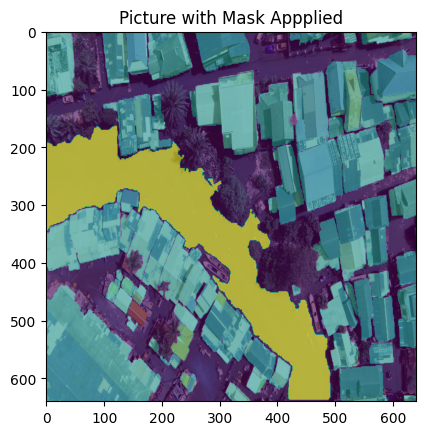

In [ ]:
#img = Image.open(IMAGE_PATH + df['id'][14] + '.JPG')
img = cv2.imread(IMAGE_PATH + df['id'][14] + '.jpg')

print(IMAGE_PATH + df['id'][14] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][14] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img) #<<
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

# Dataset

In [ ]:
from torch.utils.data.distributed import Dataset
class DroneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)



        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']




        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)

        mask = torch.from_numpy(mask).long()




        if self.patches:
            img, mask = self.tiles(img, mask)
        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)

        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)

        img_patches = img_patches.permute(1,0,2,3)


        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)



In [ ]:
a,b = train[1]



# Model

In [ ]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=2, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 59.0MB/s]


In [ ]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

# Training

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data

            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
max_lr = 1e-3
epoch = 30
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.343 
Epoch:1/30.. Train Loss: 0.523.. Val Loss: 0.343.. Train mIoU:0.803.. Val mIoU: 0.831.. Train Acc:0.886.. Val Acc:0.907.. Time: 5.08m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.343 >> 0.276 
Epoch:2/30.. Train Loss: 0.319.. Val Loss: 0.276.. Train mIoU:0.826.. Val mIoU: 0.819.. Train Acc:0.903.. Val Acc:0.904.. Time: 5.08m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.276 >> 0.245 
Epoch:3/30.. Train Loss: 0.270.. Val Loss: 0.245.. Train mIoU:0.829.. Val mIoU: 0.843.. Train Acc:0.906.. Val Acc:0.914.. Time: 5.09m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.245 >> 0.232 
saving model...
Epoch:4/30.. Train Loss: 0.248.. Val Loss: 0.232.. Train mIoU:0.834.. Val mIoU: 0.846.. Train Acc:0.910.. Val Acc:0.915.. Time: 5.12m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/30.. Train Loss: 0.247.. Val Loss: 0.247.. Train mIoU:0.834.. Val mIoU: 0.829.. Train Acc:0.908.. Val Acc:0.908.. Time: 5.01m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.247 >> 0.233 
Epoch:6/30.. Train Loss: 0.244.. Val Loss: 0.233.. Train mIoU:0.835.. Val mIoU: 0.843.. Train Acc:0.909.. Val Acc:0.915.. Time: 5.05m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:7/30.. Train Loss: 0.233.. Val Loss: 0.252.. Train mIoU:0.842.. Val mIoU: 0.836.. Train Acc:0.913.. Val Acc:0.909.. Time: 5.06m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.252 >> 0.219 
Epoch:8/30.. Train Loss: 0.218.. Val Loss: 0.219.. Train mIoU:0.850.. Val mIoU: 0.855.. Train Acc:0.918.. Val Acc:0.921.. Time: 5.01m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.219 >> 0.216 
Epoch:9/30.. Train Loss: 0.241.. Val Loss: 0.216.. Train mIoU:0.838.. Val mIoU: 0.859.. Train Acc:0.909.. Val Acc:0.922.. Time: 5.01m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.216 >> 0.216 
Epoch:10/30.. Train Loss: 0.208.. Val Loss: 0.216.. Train mIoU:0.857.. Val mIoU: 0.856.. Train Acc:0.922.. Val Acc:0.921.. Time: 5.04m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.216 >> 0.208 
saving model...
Epoch:11/30.. Train Loss: 0.195.. Val Loss: 0.208.. Train mIoU:0.866.. Val mIoU: 0.870.. Train Acc:0.927.. Val Acc:0.927.. Time: 5.05m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.208 >> 0.203 
Epoch:12/30.. Train Loss: 0.197.. Val Loss: 0.203.. Train mIoU:0.864.. Val mIoU: 0.871.. Train Acc:0.925.. Val Acc:0.927.. Time: 5.02m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:13/30.. Train Loss: 0.203.. Val Loss: 0.210.. Train mIoU:0.860.. Val mIoU: 0.865.. Train Acc:0.923.. Val Acc:0.924.. Time: 5.04m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:14/30.. Train Loss: 0.199.. Val Loss: 0.267.. Train mIoU:0.863.. Val mIoU: 0.839.. Train Acc:0.925.. Val Acc:0.909.. Time: 5.04m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.267 >> 0.200 
Epoch:15/30.. Train Loss: 0.193.. Val Loss: 0.200.. Train mIoU:0.866.. Val mIoU: 0.870.. Train Acc:0.927.. Val Acc:0.928.. Time: 5.01m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.200 >> 0.190 
Epoch:16/30.. Train Loss: 0.179.. Val Loss: 0.190.. Train mIoU:0.876.. Val mIoU: 0.875.. Train Acc:0.932.. Val Acc:0.930.. Time: 5.04m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.190 >> 0.189 
Epoch:17/30.. Train Loss: 0.173.. Val Loss: 0.189.. Train mIoU:0.881.. Val mIoU: 0.875.. Train Acc:0.934.. Val Acc:0.931.. Time: 5.06m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.189 >> 0.186 
saving model...
Epoch:18/30.. Train Loss: 0.169.. Val Loss: 0.186.. Train mIoU:0.883.. Val mIoU: 0.876.. Train Acc:0.935.. Val Acc:0.931.. Time: 5.08m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:19/30.. Train Loss: 0.168.. Val Loss: 0.187.. Train mIoU:0.884.. Val mIoU: 0.875.. Train Acc:0.936.. Val Acc:0.931.. Time: 4.99m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.187 >> 0.186 
Epoch:20/30.. Train Loss: 0.165.. Val Loss: 0.186.. Train mIoU:0.885.. Val mIoU: 0.877.. Train Acc:0.937.. Val Acc:0.931.. Time: 5.04m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.186 >> 0.182 
Epoch:21/30.. Train Loss: 0.160.. Val Loss: 0.182.. Train mIoU:0.889.. Val mIoU: 0.876.. Train Acc:0.939.. Val Acc:0.932.. Time: 5.05m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.182 >> 0.179 
Epoch:22/30.. Train Loss: 0.153.. Val Loss: 0.179.. Train mIoU:0.893.. Val mIoU: 0.877.. Train Acc:0.941.. Val Acc:0.933.. Time: 4.97m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.179 >> 0.177 
Epoch:23/30.. Train Loss: 0.150.. Val Loss: 0.177.. Train mIoU:0.895.. Val mIoU: 0.881.. Train Acc:0.942.. Val Acc:0.934.. Time: 4.95m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.177 >> 0.174 
saving model...
Epoch:24/30.. Train Loss: 0.146.. Val Loss: 0.174.. Train mIoU:0.897.. Val mIoU: 0.882.. Train Acc:0.943.. Val Acc:0.934.. Time: 4.95m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.174 >> 0.168 
Epoch:25/30.. Train Loss: 0.143.. Val Loss: 0.168.. Train mIoU:0.898.. Val mIoU: 0.888.. Train Acc:0.945.. Val Acc:0.937.. Time: 4.90m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.168 >> 0.168 
Epoch:26/30.. Train Loss: 0.141.. Val Loss: 0.168.. Train mIoU:0.901.. Val mIoU: 0.887.. Train Acc:0.945.. Val Acc:0.937.. Time: 4.93m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.168 >> 0.163 
Epoch:27/30.. Train Loss: 0.140.. Val Loss: 0.163.. Train mIoU:0.900.. Val mIoU: 0.889.. Train Acc:0.945.. Val Acc:0.938.. Time: 4.97m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:28/30.. Train Loss: 0.135.. Val Loss: 0.167.. Train mIoU:0.903.. Val mIoU: 0.889.. Train Acc:0.947.. Val Acc:0.937.. Time: 5.02m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Decreasing.. 0.167 >> 0.164 
Epoch:29/30.. Train Loss: 0.135.. Val Loss: 0.164.. Train mIoU:0.904.. Val mIoU: 0.887.. Train Acc:0.947.. Val Acc:0.938.. Time: 4.96m


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 150.59 m


In [ ]:
torch.save(model, 'Unet-Mobilenet.pt')

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

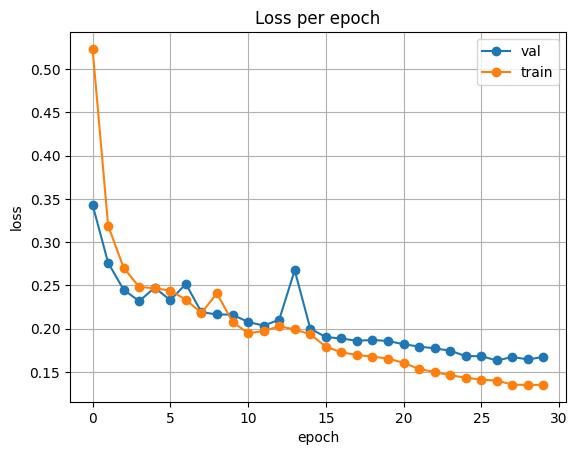

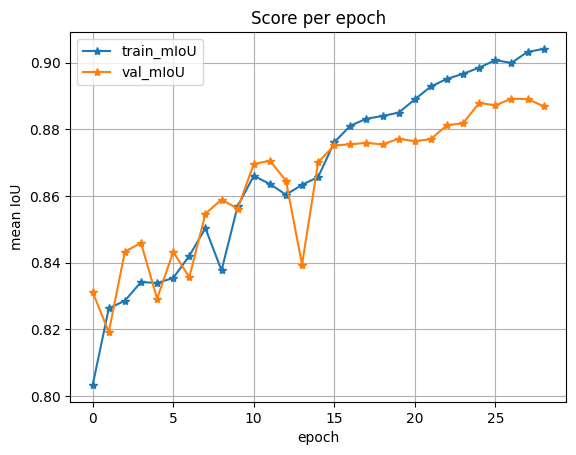

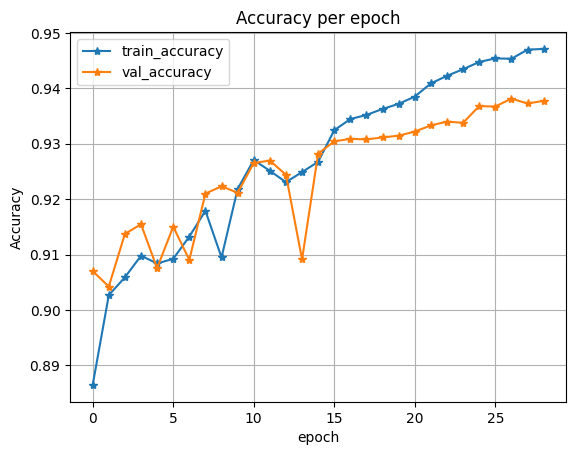

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# Evaluation

In [ ]:
class DroneTestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

## Result

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [ ]:
image, mask = test_set[4]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/159 [00:00<?, ?it/s]

In [ ]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [ ]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/159 [00:00<?, ?it/s]

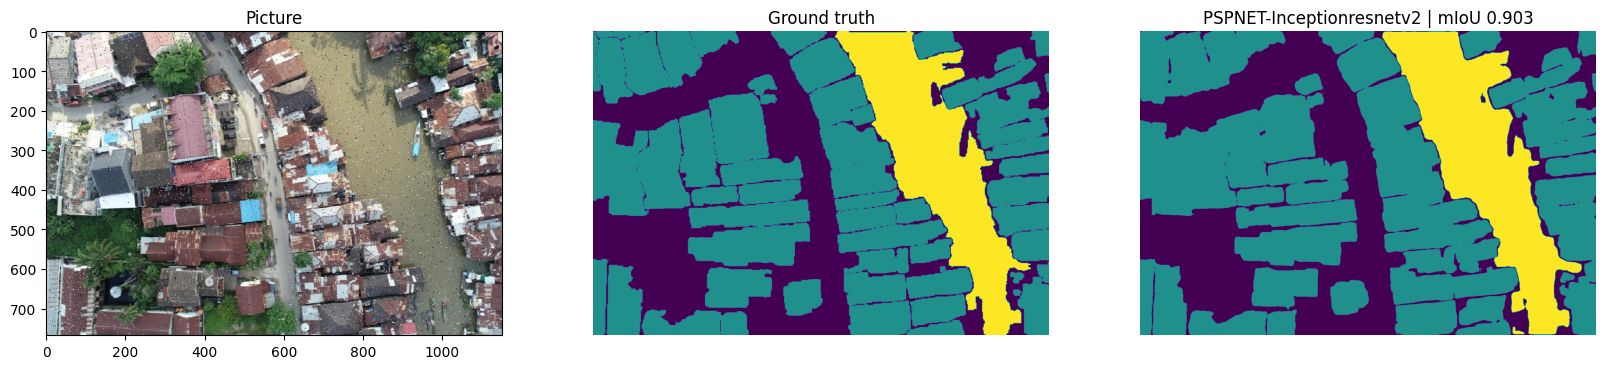

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

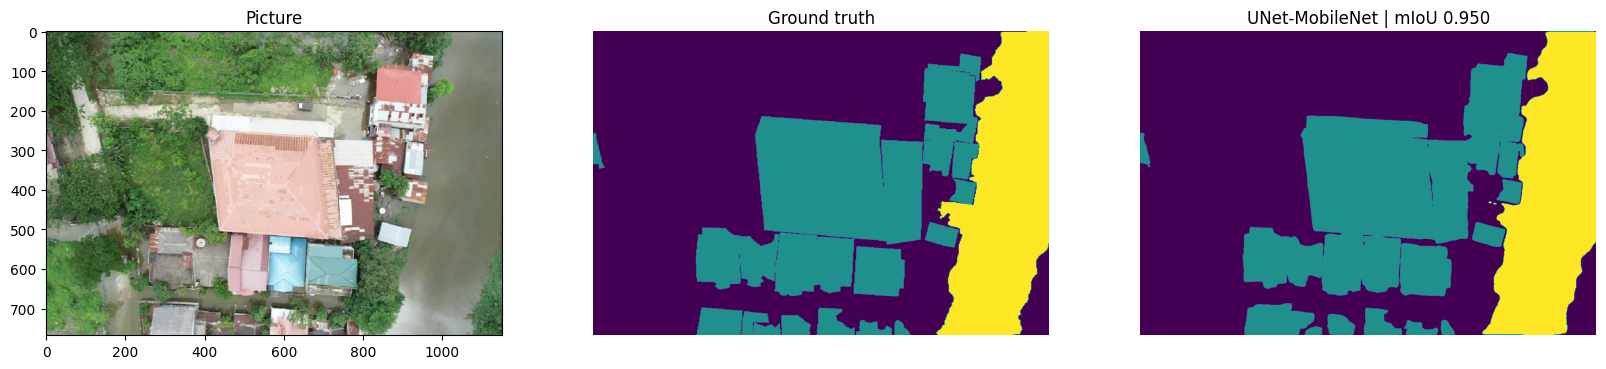

In [ ]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

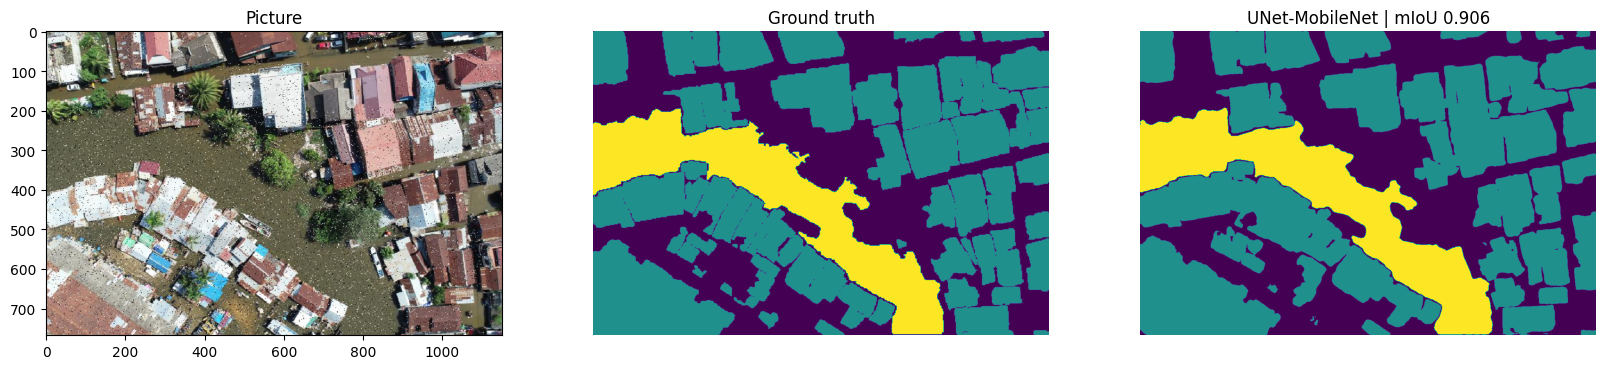

In [ ]:
image3, mask3 = test_set[3]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.9009582419906115


In [ ]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.9484365104712613
